In [ ]:
import numpy as np

# Import the qiskit library
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit_ibm_runtime import Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from itertools import product
import scipy.linalg
import matplotlib.pyplot as plt
import cvxpy as cp


## State Generation

In [ ]:
# ---------- n-qubit Pauli 演算子 ----------
def get_pauli_matrices():
    """単一qubitのPauli演算子"""
    I = np.array([[1, 0], [0, 1]], dtype=complex)
    X = np.array([[0, 1], [1, 0]], dtype=complex)
    Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    Z = np.array([[1, 0], [0, -1]], dtype=complex)
    return [I, X, Y, Z]

def get_n_qubit_paulis(n):
    """n-qubit の全Pauli演算子を生成"""
    single_paulis = get_pauli_matrices() #[I, X, Y, Z]
    labels = ['I', 'X', 'Y', 'Z']
    paulis = []
    for indices in product(range(4), repeat=n): #[indices=(0,0,...,0),...,(1,1,...1)]みたいなnタプルのリストを作っている
        label = ''.join(labels[i] for i in indices) # indeces = (0, 1, 2) -> "IXY"
        mat = single_paulis[indices[0]] #タプルの先頭
        for idx in indices[1:]: #タプルの先頭を除いた部分
            mat = np.kron(mat, single_paulis[idx]) #テンソル積を繰り返して 2^n × 2^n の Pauli sequence を作成
        paulis.append((label, mat)) #labelと行列のタプル
    return paulis #[("III", I otimes I otimes I), ..., ("ZZZ", Z otimes Z otimes Z) ]ラベルと行列のタプル4^n個のリスト


# ---------- Pauli rank k^2 以下の状態生成 ----------
def random_pauli_rank_leq_k2_state(n, k):
    """
    Hermite行列HをPauli rank kで作成し、
    rho = H^dag H / Tr[H^dag H]で量子状態を生成
    最大Pauli rankは k^2
    """
    
    paulis = get_n_qubit_paulis(n)
    dim = 2 ** n
    
    # Pauli rank kにランダム選択 (Iを必ず含める)
    paulis_selected = ['I' * n]
    if k > 1:
        pauli_indices = np.random.choice(range(1, len(paulis)), size=k-1, replace=False) #replace=False 重複しないように
        paulis_selected += [paulis[i][0] for i in pauli_indices] #選ばれたk個のPauli basisのラベルのリスト eg.["II", "IX", "ZX"]

    # Hermite行列 H = sum_i c_i P_i
    H = np.zeros((dim, dim), dtype=complex) #entryすべて0の2^n times 2^n 行列を準備
    for idx in paulis_selected:
        _, P = next((l, m) for (l, m) in paulis if l == idx) #ラベルに合う要素を見つけて、その要素を返している
        c = np.random.randn() # ランダム実係数
        H += c * P # H = sum_{i=1}^k c_i P_i ができる

    # PSD化して trace=1 に正規化
    rho = H.conj().T @ H # @は行列積
    rho /= np.trace(rho) # rho = H^dag H / Tr[H^dag H]

    print(f"Selected k Pauli basis = {paulis_selected}")
    return rho

# ---------- 実際のPauli rankの計算 ----------
def pauli_rank_of_rho(rho, n, tol=1e-10):
    """密度行列の実際のPauli rankを計算"""
    paulis = get_n_qubit_paulis(n)
    dim = 2 ** n
    count = 0
    coeff_list = []
    for lbl, P in paulis:
        coeff = np.trace(rho @ P) / dim # rho = sum_P coeff_P P
        if np.abs(coeff) > tol:
            count += 1
            coeff_list.append((lbl, coeff))
    return count, coeff_list #非零のPauli係数の個数を返す



## Check State Genaration

In [52]:
# ---------- random_pauli_rank_leq_k2_stateで生成した行列が状態になってるかcheck ----------
n = 6
k = 3

rho = random_pauli_rank_leq_k2_state(n, k)

# 1. Hermitian チェック
hermitian_check = np.allclose(rho, rho.conj().T)
print("Hermitian:", hermitian_check)

# 2. Trace = 1 チェック
trace_check = np.isclose(np.trace(rho), 1.0)
print("Trace = 1:", trace_check)

# 3. PSD チェック
eigvals = np.linalg.eigvalsh(rho)  # Hermitian 行列なので eigvalsh を使う
psd_check = np.all(eigvals >= -1e-12)  # 数値誤差を考慮
print("Positive Semi-Definite:", psd_check)
#print("Eigenvalues:", eigvals)

# 4. Pauli rank チェック
count, coeff_list = pauli_rank_of_rho(rho, n)
print(f"Actual Pauli rank = {count}")
#for lbl, c in coeff_list:
#    print(f"{lbl}: {c:.4f}")

Selected k Pauli basis = ['IIIIII', 'ZZZIZZ', 'YIZZIZ']
Hermitian: True
Trace = 1: True
Positive Semi-Definite: True
Actual Pauli rank = 3


## State Reconstruction via Shadow Tomography

In [ ]:

# ---------- Random Pauli 測定をシミュレーション ----------
def sample_pauli_measurement(rho, bases):
    """
    密度行列 rho に対して、指定された Pauli bases での測定をシミュレート
    Parameters:
    - rho: 密度行列
    - bases: 各qubitの測定basisを表す長さnの配列(0:Z, 1:X, 2:Y)
    Returns:
    - bitstring: 測定結果のビット列
    """
    n = len(bases)
    dim = 2 ** n
    
    # 測定用の基底変換ユニタリを構築
    U_total = np.eye(1, dtype=complex) # 1 times 1 の行列を頭に作っておく
    U_list = []

    for i in range(n):
        if bases[i] == 0:  # Z basis
            U = np.eye(2, dtype=complex)
        elif bases[i] == 1:  # X basis
            U = np.array([[1, 1], [1, -1]], dtype=complex) / np.sqrt(2) # Hadamard^dag
        elif bases[i] == 2:  # Y basis
            U = np.array([[1, -1j], [1, 1j]], dtype=complex) / np.sqrt(2) # Z -> Y のdag
        
        U_list.append(U) # 使用した局所ユニタリのリストも作成しておく
        U_total = np.kron(U_total, U) # 測定の basis が ZXZYXYZ...Y みたいな感じに合わせてユニタリ変換を作っておく
    
    # 基底変換後の密度行列
    rho_rot = U_total @ rho @ U_total.conj().T
    
    # 対角成分が測定確率
    probs = np.real(np.diag(rho_rot))
    probs = np.maximum(probs, 0)
    probs /= np.sum(probs)
    
    # 測定結果をサンプリング
    outcome = np.random.choice(dim, p=probs) #0～dim-1 の整数を probs に従ってランダムに選ぶ
    bitstring = format(outcome, f'0{n}b') #整数を n ビットの 2 進数文字列に変換
    
    return bitstring, U_list

def classical_shadow_reconstruction(rho_true, n, shadow_size=1000, block_size=None):
    """
    Classical Shadow tomography 正確版 (n-qubit 全体をテンソル積で計算)
    """
    dim = 2 ** n
    paulis = get_n_qubit_paulis(n)

    # ブロック構造
    if block_size is None:
        block_size = max(10, shadow_size // 10) # block 内の個数
    n_blocks = max(1, shadow_size // block_size) # number of blocks

    pauli_estimates_blocks = {lbl: [] for lbl, _ in paulis} # Pauli 演算子ごとの推定値を格納する箱を用意

    for _ in range(n_blocks):
        pauli_block_estimates = {lbl: [] for lbl, _ in paulis} # 各 Pauli ラベルの期待値を記録するリストを初期化

        for _ in range(block_size):
            bases = np.random.randint(0, 3, size=n) # ランダムPauli基底を選ぶ
            bitstring, U_list = sample_pauli_measurement(rho_true, bases) #選ばれた基底 bases に対して、密度行列 rho_true の測定をシミュレーション。bitstring は n ビットの文字列で、各 qubit の測定結果

            # n-qubit snapshot をテンソル積で作る
            rho_snapshot = np.array([[1]], dtype=complex) # 1 times 1 を先頭に
            for i in range(n):
                # 測定結果による射影
                if bitstring[i] == '0':
                    proj = np.array([[1, 0], [0, 0]], dtype=complex) # |0><0|
                else:
                    proj = np.array([[0, 0], [0, 1]], dtype=complex) # |1><1|

                rho_i = 3 * (U_list[i].conj().T @ proj @ U_list[i]) - np.eye(2)
                rho_snapshot = np.kron(rho_snapshot, rho_i)

            # 各 Pauli 演算子の期待値を正確に計算
            for lbl, P in paulis:
                expectation = float(np.real(np.trace(P @ rho_snapshot))) # Tr[P hat{rho}]を全ての Pauli 基底で
                pauli_block_estimates[lbl].append(expectation) # pauli_block_estimates[lbl] は 1 ブロック内の snapshot から得た推定値のリスト
                                                               #pauli_block_estimates[lbl] に append して、同じブロック内の他の snapshot とまとめて平均を取れるように
        # ブロック平均
        for lbl in pauli_block_estimates:
            pauli_estimates_blocks[lbl].append(np.mean(pauli_block_estimates[lbl])) #各ブロックで平均をとる eg. 4 blocks: pauli_estimates_blocks = {'IXY':[0.95, 1.02, 0.98, 1.01], ...}

    # median-of-means。 vals が各ブロックの平均リスト
    pauli_estimates_final = {lbl: np.median(vals) for lbl, vals in pauli_estimates_blocks.items()} # np.median(vals) で ブロック間の中央値 を計算し、最終的な Pauli 推定値にする

    # 密度行列再構成　この時、 rho_est は正確には密度行列ではないことに注意
    rho_est = np.zeros((dim, dim), dtype=complex)
    for lbl, P in paulis:
        rho_est += pauli_estimates_final[lbl] * P / dim

    return rho_est

# ---------- 物理的な量子状態へ ----------
def project_to_physical_state_trace_norm(rho_est):
    """
    rho_est から trace-norm が最小になる密度行列に
    """
    dim = rho_est.shape[0] #行列のサイズを取得
    
    # CVXPY の変数を作成。rho が最適化の対象
    rho = cp.Variable((dim, dim), complex=True)
    
    # 制約
    constraints = [
        rho >> 0,          # PSD
        cp.trace(rho) == 1, # unit trace。 CVXPY の関数で、行列の トレース
        rho == rho.H        # Hermitian。 CVXPY での Hermite conjugate
    ]
    
    # 目的関数: trace norm 最小化
    obj = cp.Minimize(cp.norm(rho - rho_est, "nuc"))  # "nuc" = trace norm
    
    prob = cp.Problem(obj, constraints) # 第一引数に目的関数、第二引数に制約
    prob.solve(solver=cp.SCS, verbose=False) #solve メソッドで問題を解きます。solver=cp.SCS は SCS ソルバー を指定。verbose=False で途中の出力を抑制。解が存在すれば、rho.value に最適解が格納。
    
    return rho.value

# ---------- Trace distance を計算----------
def trace_distance(rho1, rho2):
    """トレース距離: D(rho, sigma) = (1/2) * Tr[|rho - sigma|]"""
    diff = rho1 - rho2

    # |A| = sqrt(A†A)
    sqrt_term = scipy.linalg.sqrtm(diff.conj().T @ diff) #scipy.linalg.sqrtm(A) = sqrt{A}
    # 実部を取ってトレース
    return 0.5 * np.real(np.trace(sqrt_term))

# Implementation of Classical Shadow Tomography


=== Classical Shadow Tomography (n = 3, k = 2 (Pauli rank <= 4)) ===
Selected k Pauli basis = ['III', 'ZII']
Actual Pauli rank = 2
shadow size = 200, Trace distance = 0.5318
shadow size = 600, Trace distance = 0.4436
shadow size = 1000, Trace distance = 0.3976
shadow size = 5000, Trace distance = 0.1975
shadow size = 9000, Trace distance = 0.1397
shadow size = 13000, Trace distance = 0.1501
shadow size = 17000, Trace distance = 0.1181
shadow size = 21000, Trace distance = 0.0952

=== Classical Shadow Tomography (n = 3, k = 4 (Pauli rank <= 16)) ===
Selected k Pauli basis = ['III', 'XXX', 'ZZX', 'XYY']
Actual Pauli rank = 6
shadow size = 200, Trace distance = 0.4393
shadow size = 600, Trace distance = 0.4102
shadow size = 1000, Trace distance = 0.3846
shadow size = 5000, Trace distance = 0.1883
shadow size = 9000, Trace distance = 0.1623
shadow size = 13000, Trace distance = 0.1069
shadow size = 17000, Trace distance = 0.1127
shadow size = 21000, Trace distance = 0.0894

=== Classical 

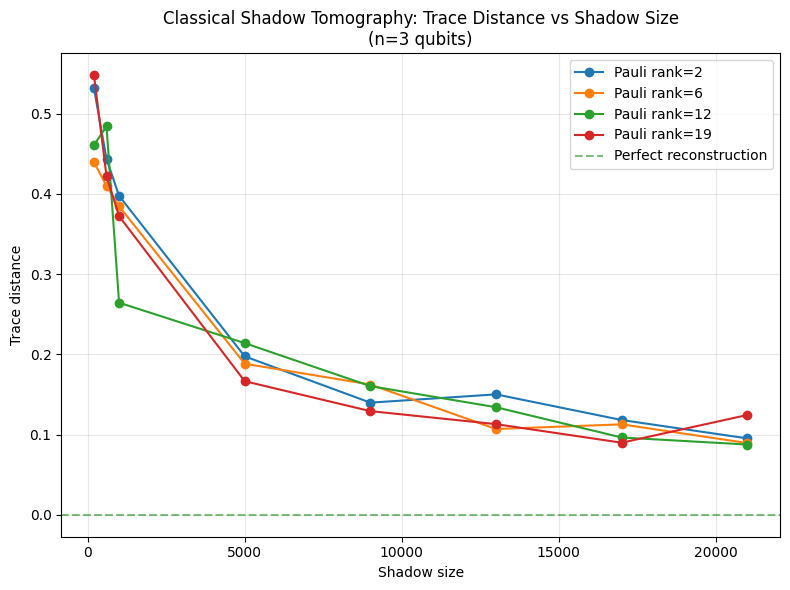

In [59]:
# ---------- 実行 ----------
if __name__=="__main__":
    # np.random.seed(42)  # 全体の再現性
    n = 3 # qubits 数
    k_list = [2, 4, 6, 8]  # k を変えて比較
    shadow_sizes = [200, 600, 1000, 5000, 9000, 13000, 17000, 21000]

    plt.figure(figsize=(8,6)) #描画領域の作成

    for k in k_list:
        print(f"\n=== Classical Shadow Tomography (n = {n}, k = {k} (Pauli rank <= {k**2})) ===")
        # 別の状態を生成する場合は seed=None
        rho_true = random_pauli_rank_leq_k2_state(n, k)
        pauli_rank, _ = pauli_rank_of_rho(rho_true, n, tol=1e-10)
        print(f"Actual Pauli rank = {pauli_rank}")
        
        trace_distances = []
        for s in shadow_sizes:
            rho_est = classical_shadow_reconstruction(rho_true, n, shadow_size=s)
            rho_est_phys = project_to_physical_state_trace_norm(rho_est)
            dist = trace_distance(rho_true, rho_est_phys)
            trace_distances.append(dist)
            print(f"shadow size = {s}, Trace distance = {dist:.4f}")  # ここで出力
        
        plt.plot(shadow_sizes, trace_distances, 'o-', label=f'Pauli rank={pauli_rank}')
    
    plt.axhline(y=0.0, color='g', linestyle='--', alpha=0.5, label='Perfect reconstruction')
    plt.xlabel("Shadow size")
    plt.ylabel("Trace distance")
    plt.title(f"Classical Shadow Tomography: Trace Distance vs Shadow Size\n(n={n} qubits)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ======Full Tomography =======

In [ ]:
def full_qst(rho_true, n, shadow_size):
    """
    Full quantum state tomography (Pauli basis) を行う
    shadow_size: 総コピー数
    """
    dim = 2 ** n
    paulis = get_n_qubit_paulis(n) #paulis は (label, matrix) のタプルのリスト
    n_paulis = len(paulis)
    
    # 各 Pauli basis に割り当てるコピー数
    base_count = shadow_size // n_paulis
    extra = shadow_size % n_paulis
    
    pauli_copy_counts = [base_count] * n_paulis #全Pauliに base_count を割り当てたリスト
    # 余りをランダムに割り当て
    for i in np.random.choice(range(n_paulis), extra, replace=False):
        pauli_copy_counts[i] += 1
    
    pauli_estimates = {} #期待値を格納する辞書
    
    for idx, (lbl, P) in enumerate(paulis): #enumerate により、リストの インデックス idx と タプル (lbl, P)を取得。 idx は0から len(paulis)-1 まで
        n_copies = pauli_copy_counts[idx] #例えば shadow_size=200, n_paulis=64 の場合、ほとんどの Pauli basis で 3 コピー、余り分の8個だけ 4 コピーになる。
        if n_copies == 0:
            pauli_estimates[lbl] = 0.0
            continue
        
        # 単一 Pauli に対して n_copies の測定をシミュレーション
        # ここでは理想的に Tr[P rho] をサンプリングする。つまり確率的に ±1 を n_copies 回サンプリング
        res_list = np.random.choice([1, -1], size=n_copies, p=[
            (1 + np.real(np.trace(P @ rho_true))) / 2,
            (1 - np.real(np.trace(P @ rho_true))) / 2
        ]) # eg. res_list = [1, 1, -1, 1, -1, -1,...]
        pauli_estimates[lbl] = np.mean(res_list)
    
    # rho_est の再構成
    rho_est = np.zeros((dim, dim), dtype=complex)
    for lbl, P in paulis:
        rho_est += pauli_estimates[lbl] * P / dim
    
    # 物理的状態に射影
    rho_est_phys = project_to_physical_state_trace_norm(rho_est)
    
    return rho_est_phys


In [ ]:
# ---------- 実行 ----------  
if __name__=="__main__":
    n = 3 # qubits 数
    k_list = [2, 4, 6, 8]  # k を変えて比較
    shadow_sizes = [200, 600, 1000, 5000, 9000, 13000, 17000, 21000]

    plt.figure(figsize=(8,6))  # 描画領域の作成

    for k in k_list:
        print(f"\n=== Classical Shadow & Full QST (n = {n}, k = {k} (Pauli rank <= {k**2})) ===")
        rho_true = random_pauli_rank_leq_k2_state(n, k) # 状態生成
        pauli_rank, _ = pauli_rank_of_rho(rho_true, n, tol=1e-10)
        print(f"Actual Pauli rank = {pauli_rank}")
        
        trace_distances_shadow = []
        trace_distances_fullqst = []
        
        for s in shadow_sizes:
            # ---------------- Classical Shadow Tomography----------------
            rho_est_shadow_phys = classical_shadow_reconstruction(rho_true, n, shadow_size=s)
            dist_shadow = trace_distance(rho_true, rho_est_shadow_phys)
            trace_distances_shadow.append(dist_shadow)
            
            # ---------------- Full QST ----------------
            rho_est_fullqst_phys = full_qst(rho_true, n, shadow_size=s)
            dist_fullqst = trace_distance(rho_true, rho_est_fullqst_phys)
            trace_distances_fullqst.append(dist_fullqst)
            
            print(f"shadow size = {s}, Trace distance (Shadow) = {dist_shadow:.4f}, Trace distance (Full QST) = {dist_fullqst:.4f}")
        
        # プロット
        plt.plot(shadow_sizes, trace_distances_shadow, 'o-', label=f'Shadow, Pauli rank={pauli_rank}')
        plt.plot(shadow_sizes, trace_distances_fullqst, 's--', label=f'Full QST, Pauli rank={pauli_rank}')

    plt.axhline(y=0.0, color='g', linestyle='--', alpha=0.5, label='Perfect reconstruction')
    plt.xlabel("Total copies (shadow size)")
    plt.ylabel("Trace distance")
    plt.title(f"Classical Shadow vs Full QST: Trace Distance vs Copies\n(n={n} qubits)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
